<a href="https://colab.research.google.com/github/supertime1/BERT/blob/main/QA_BERT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Import Dependencies

In [1]:
import os
import tensorflow.keras as keras
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
from official.nlp import optimization
import numpy as np
import json
from tokenizers import BertWordPieceTokenizer
import string
import re

tf.get_logger().setLevel('ERROR')

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9391108782746072479
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6518474828
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1375699206776563173
physical_device_desc: "device: 0, name: Quadro RTX 4000, pci bus id: 0000:02:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 6518474828
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2535449235004026885
physical_device_desc: "device: 1, name: Quadro RTX 4000, pci bus id: 0000:05:00.0, compute capability: 7.5"
, name: "/device:GPU:2"
device_type: "GPU"
memory_limit: 6518474828
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4894919672722859729
physical_device_desc: "device: 2, name: Quadro RTX 4000, pci bus id: 0000:17:00.0, compute capability: 7.5"
, name: "/device:GPU:3"
device_type: "GPU"
memory_limit: 6518474828
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6144991933386974310
phys

In [3]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

True

#2.Helper functions

In [4]:
class Sample:
  def __init__(self, question, context, start_char_idx=None, answer_text=None, all_answers=None):
    self.question = question
    self.context = context
    self.start_char_idx = start_char_idx
    self.answer_text = answer_text
    self.all_answers = all_answers
    self.skip = False
    self.start_token_idx = -1
    self.end_token_idx = -1
  
  def preprocess(self):
  # remove multipe whitespace between characters
    context = " ".join(str(self.context).split())
    question = " ".join(str(self.question).split())
    # tokenize context and question
    tokenized_context = tokenizer.encode(context)
    tokenized_question = tokenizer.encode(question)
    # preprocess answer if this is a validation or training sample
    if self.answer_text:
      answer = " ".join(str(self.answer_text).split())
      # find the end character index
      end_char_idx = self.start_char_idx + len(answer)
      
      # sometimes squad answers are off by a character or two – fix this
      if context[self.start_char_idx-1:end_char_idx-1] == answer:
          self.start_char_idx -= 1
          end_char_idx -= 1
      elif context[self.start_char_idx-2:end_char_idx-2] == answer:
          self.start_char_idx -= 2
          end_char_idx -= 2
      
      # check if end character index is in the context
      if end_char_idx >= len(context):
        self.skip = True
        return
      # mark all the character indexes in context that are also in answer
      is_char_in_ans = [0] * len(context)
      for idx in range(self.start_char_idx, end_char_idx):
        is_char_in_ans[idx] = 1
      # find all the tokens that are in the answers
      ans_token_idx = []
      for idx, (start, end) in enumerate(tokenized_context.offsets):
        if sum(is_char_in_ans[start:end]) > 0:
          ans_token_idx.append(idx)
      if len(ans_token_idx) == 0:
        self.skip = True
        return
      # get start and end token indexes
      self.start_token_idx = ans_token_idx[0]
      self.end_token_idx = ans_token_idx[-1]

    else:
        self.skip = True
        return

    # create inputs as usual
    input_ids = tokenized_context.ids + tokenized_question.ids[1:]
    attention_mask = [1] * len(input_ids)
    token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(tokenized_question.ids[1:])
    padding_length = max_seq_length - len(input_ids)
    # add padding if necessary
    if padding_length > 0:
      input_ids += [0] * padding_length
      attention_mask += [0] * padding_length
      token_type_ids += [0] * padding_length

    elif padding_length < 0:
      self.skip = True
      return

    self.input_word_ids = input_ids
    self.input_type_ids = token_type_ids
    self.input_mask = attention_mask
    self.context_token_to_char = tokenized_context.offsets

In [5]:
def create_squad_examples(raw_data):
    squad_examples = []
    for item in raw_data["data"]:
        for para in item["paragraphs"]:
            context = para["context"]
            for qa in para["qas"]:
                question = qa["question"]
                if qa["answers"]:
                    all_answers = [_["text"] for _ in qa["answers"]]
                    for answer in qa['answers']:
                        answer_text = answer["text"]
                        start_char_idx = qa["answers"][0]["answer_start"]
                        squad_eg = Sample(question, context, start_char_idx, answer_text, all_answers)
                else:
                    squad_eg = Sample(question, context)
                squad_eg.preprocess()
                squad_examples.append(squad_eg)
    return squad_examples

In [6]:
def create_inputs_targets(squad_examples):
    dataset_dict = {
        "input_word_ids": [],
        "input_type_ids": [],
        "input_mask": [],
        "start_token_idx": [],
        "end_token_idx": [],
    }
    for item in squad_examples:
        if item.skip == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(item, key))
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])
    x = [dataset_dict["input_word_ids"],
         dataset_dict["input_mask"],
         dataset_dict["input_type_ids"]]
    y = [dataset_dict["start_token_idx"], dataset_dict["end_token_idx"]]
    return x, y

In [7]:
class ValidationCallback(keras.callbacks.Callback):

    def normalize_text(self, text):
        # convert to lower case
        text = text.lower()
        # remove redundant whitespaces
        text = "".join(ch for ch in text if ch not in set(string.punctuation))
        # remove articles
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        text = re.sub(regex, " ", text)
        text = " ".join(text.split())
        return text

    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def on_epoch_end(self, epoch, logs=None):
        # get the offsets of the first and last tokens of predicted answers
        pred_start, pred_end = self.model.predict(self.x_eval)
        count = 0
        eval_examples_no_skip = [_ for _ in eval_squad_examples if _.skip == False]
        # for every pair of offsets
        for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
            # take the required Sample object with the ground-truth answers in it
            squad_eg = eval_examples_no_skip[idx]
            # use offsets to get back the span of text corresponding to
            # our predicted first and last tokens
            offsets = squad_eg.context_token_to_char
            start = np.argmax(start)
            end = np.argmax(end)
            if start >= len(offsets):
                continue
            pred_char_start = offsets[start][0]
            if end < len(offsets):
                pred_char_end = offsets[end][1]
                pred_ans = squad_eg.context[pred_char_start:pred_char_end]
            else:
                pred_ans = squad_eg.context[pred_char_start:]
            normalized_pred_ans = self.normalize_text(pred_ans)
            # clean the real answers
            normalized_true_ans = [self.normalize_text(_) for _ in squad_eg.all_answers]
            # check if the predicted answer is in an array of the ground-truth answers
            if normalized_pred_ans in normalized_true_ans:
                count += 1
        acc = count / len(self.y_eval[0])
        print(f"\nepoch={epoch + 1}, exact match score={acc:.2f}")  

#3.Download a BERT model and fine-tune it

In [8]:
train_path = r'C:\Users\57lzhang.US04WW4008\Documents\GitHub\BERT\dataset\train-v2.0.json'
eval_path = r'C:\Users\57lzhang.US04WW4008\Documents\GitHub\BERT\dataset\dev-v2.0.json'
with open(train_path) as f: raw_train_data = json.load(f)
with open(eval_path) as f: raw_eval_data = json.load(f)

In [9]:
max_seq_length = 384
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy().decode("utf-8")
tokenizer = BertWordPieceTokenizer(vocab=vocab_file, lowercase=True)

In [10]:
train_squad_examples = create_squad_examples(raw_train_data)
x_train, y_train = create_inputs_targets(train_squad_examples)
print(f"{len(train_squad_examples)} training points created.")

130319 training points created.


In [11]:
eval_squad_examples = create_squad_examples(raw_eval_data)
x_eval, y_eval = create_inputs_targets(eval_squad_examples)
print(f"{len(eval_squad_examples)} evaluation points created.")

# tensorflow pipeline
batch_size = 4
#train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#validation = tf.data.Dataset.from_tensor_slices((x_eval, y_eval))
#train_dataset = train.cache()
#train_dataset = train_dataset.shuffle(2048).repeat().batch(batch_size, drop_remainder=True)
#train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#val_dataset = validation.repeat().batch(batch_size, drop_remainder=True)

11873 evaluation points created.


In [12]:
# Sanity check if all sample in evaluation have all_answers not none
lst = [i for i in range(len(eval_squad_examples)) if eval_squad_examples[i].all_answers == None and eval_squad_examples[i].skip == False]
assert len(lst) == 0

In [13]:
# create model
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_word_ids')
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_mask')
input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_type_ids')
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
start_logits = tf.keras.layers.Dense(1, name="start_logit", use_bias=False)(sequence_output)
start_logits = tf.keras.layers.Flatten()(start_logits)
end_logits = tf.keras.layers.Dense(1, name="end_logit", use_bias=False)(sequence_output)
end_logits = tf.keras.layers.Flatten()(end_logits)
start_probs = tf.keras.layers.Activation(keras.activations.softmax)(start_logits)
end_probs = tf.keras.layers.Activation(keras.activations.softmax)(end_logits)
model = keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=[start_probs, end_probs])

# setup compile
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(optimizer=optimizer, loss=[loss, loss], metrics='accuracy')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 384)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

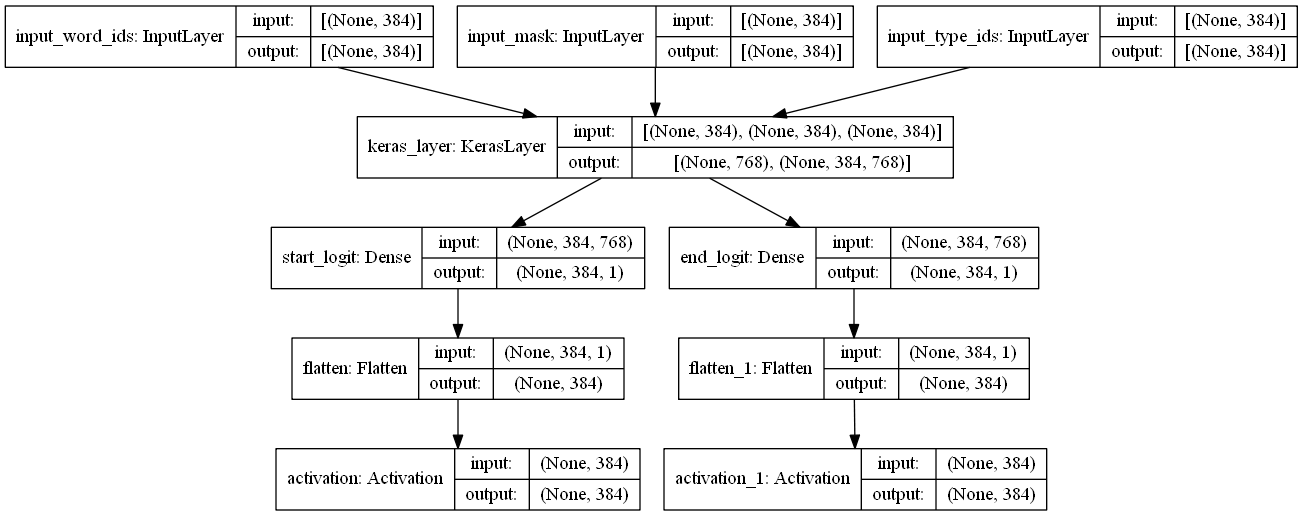

In [14]:
model.summary()
tf.keras.utils.plot_model(model, "C:/Users/57lzhang.US04WW4008/Desktop/multi_input_and_output_model.png", show_shapes=True)

##Training

In [ ]:
model.fit(x_train, y_train, epochs=2, batch_size=batch_size, validation_data=(x_eval, y_eval))

#4.Evaluate the QA model

In [ ]:
def get_span_from_scores(start_scores, end_scores, input_mask, verbose=False):
    """
    Find start and end indices that maximize sum of start score
    and end score, subject to the constraint that start is before end
    and both are valid according to input_mask.

    Args:
        start_scores (list): contains scores for start positions, shape (1, n)
        end_scores (list): constains scores for end positions, shape (1, n)
        input_mask (list): 1 for valid positions and 0 otherwise
    """
    n = len(start_scores)
    max_start_i = -1
    max_end_j = -1
    max_start_score = -np.inf
    max_end_score = -np.inf
    max_sum = -np.inf
    
    # Find i and j that maximizes start_scores[i] + end_scores[j]
    # so that i <= j and input_mask[i] == input_mask[j] == 1
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # set the range for i
    for i in range(n): # complete this line
        
        # set the range for j
        for j in range(i,n): #complete this line

            # both input masks should be 1
            if input_mask[i] == input_mask[j] == 1: # complete this line
                
                # check if the sum of the start and end scores is greater than the previous max sum
                if start_scores[i] + end_scores[j] > max_sum: # complete this line

                    # calculate the new max sum
                    max_sum = start_scores[i] + end_scores[j]
        
                    # save the index of the max start score
                    max_start_i = i
                
                    # save the index for the max end score
                    max_end_j = j
                    
                    # save the value of the max start score
                    max_start_val = start_scores[i]
                    
                    # save the value of the max end score
                    max_end_val = end_scores[j]
                                        
    ### END CODE HERE ###
    if verbose:
        print(f"max start is at index i={max_start_i} and score {max_start_val}")
        print(f"max end is at index i={max_end_j} and score {max_end_val}")
        print(f"max start + max end sum of scores is {max_sum}")
    return max_start_i, max_end_j

In [ ]:
start_scores = tf.convert_to_tensor([-1, 2, 0.4, -0.3, 0, 8, 10, 12], dtype=float)
end_scores = tf.convert_to_tensor([5, 1, 1, 3, 4, 10, 10, 10], dtype=float)
input_mask = [1, 1, 1, 1, 1, 0, 0, 0]

start, end = get_span_from_scores(start_scores, end_scores, input_mask, verbose=True)

print("Expected: (1, 4) \nReturned: ({}, {})".format(start, end))

In [ ]:
# Test 2

start_scores = tf.convert_to_tensor([0, 2, -1, 0.4, -0.3, 0, 8, 10, 12], dtype=float)
end_scores = tf.convert_to_tensor([0, 5, 1, 1, 3, 4, 10, 10, 10], dtype=float)
input_mask = [1, 1, 1, 1, 1, 0, 0, 0, 0 ]

start, end = get_span_from_scores(start_scores, end_scores, input_mask, verbose=True)

print("Expected: (1, 1) \nReturned: ({}, {})".format(start, end))

In [ ]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def construct_answer(tokens):
    """
    Combine tokens into a string, remove some hash symbols, and leading/trailing whitespace.
    Args:
        tokens: a list of tokens (strings)
    
    Returns:
        out_string: the processed string.
    """
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # join the tokens together with whitespace
    out_string = " ".join(tokens)
    
    # replace ' ##' with empty string
    out_string = out_string.replace(' ##','')
    
    # remove leading and trailing whitespace
    out_string = out_string.strip()

    ### END CODE HERE ###
    
    # if there is an '@' symbol in the tokens, remove all whitespace
    if '@' in tokens:
        out_string = out_string.replace(' ', '')

    return out_string

In [ ]:
# Test

tmp_tokens_1 = [' ## hello', 'how ', 'are ', 'you?      ']
tmp_out_string_1 = construct_answer(tmp_tokens_1)

print(f"tmp_out_string_1: {tmp_out_string_1}, length {len(tmp_out_string_1)}")


tmp_tokens_2 = ['@',' ## hello', 'how ', 'are ', 'you?      ']
tmp_out_string_2 = construct_answer(tmp_tokens_2)
print(f"tmp_out_string_2: {tmp_out_string_2}, length {len(tmp_out_string_2)}")


In [ ]:
def get_model_answer(model, question, passage, tokenizer, max_seq_length=384):
    """
    Identify answer in passage for a given question using BERT. 

    Args:
        model (Model): pretrained Bert model which we'll use to answer questions
        question (string): question string
        passage (string): passage string
        tokenizer (Tokenizer): used for preprocessing of input
        max_seq_length (int): length of input for model
        
    Returns:
        answer (string): answer to input question according to model
    """ 
    # prepare input: use the function prepare_bert_input
    input_ids, input_mask, tokens = prepare_bert_input(question, passage, tokenizer, max_seq_length)
    
    # get scores for start of answer and end of answer
    # use the model returned by TFAutoModelForQuestionAnswering.from_pretrained("./models")
    # pass in in the input ids that are returned by prepare_bert_input
    start_scores, end_scores = model(input_ids)
    
    # start_scores and end_scores will be tensors of shape [1,max_seq_length]
    # To pass these into get_span_from_scores function, 
    # take the value at index 0 to get a tensor of shape [max_seq_length]
    start_scores = start_scores[0]
    end_scores = end_scores[0]
    
    # using scores, get most likely answer
    # use the get_span_from_scores function
    span_start, span_end = get_span_from_scores(start_scores, end_scores, input_mask)
    
    # Using array indexing to get the tokens from the span start to span end (including the span_end)
    answer_tokens = tokens[span_start:span_end+1]
    
    # Combine the tokens into a single string and perform post-processing
    # use construct_answer
    answer = construct_answer(answer_tokens)
    
    return answer

In [ ]:
passage = "Computational complexity theory is a branch of the theory \
           of computation in theoretical computer science that focuses \
           on classifying computational problems according to their inherent \
           difficulty, and relating those classes to each other. A computational \
           problem is understood to be a task that is in principle amenable to \
           being solved by a computer, which is equivalent to stating that the \
           problem may be solved by mechanical application of mathematical steps, \
           such as an algorithm."

question = "What branch of theoretical computer science deals with broadly \
            classifying computational problems by difficulty and class of relationship?"

print("Output: {}".format(get_model_answer(model, question, passage, tokenizer)))
print("Expected: Computational complexity theory")

In [ ]:
passage = "The word pharmacy is derived from its root word pharma which was a term used since \
           the 15th–17th centuries. However, the original Greek roots from pharmakos imply sorcery \
           or even poison. In addition to pharma responsibilities, the pharma offered general medical \
           advice and a range of services that are now performed solely by other specialist practitioners, \
           such as surgery and midwifery. The pharma (as it was referred to) often operated through a \
           retail shop which, in addition to ingredients for medicines, sold tobacco and patent medicines. \
           Often the place that did this was called an apothecary and several languages have this as the \
           dominant term, though their practices are more akin to a modern pharmacy, in English the term \
           apothecary would today be seen as outdated or only approproriate if herbal remedies were on offer \
           to a large extent. The pharmas also used many other herbs not listed. The Greek word Pharmakeia \
           (Greek: φαρμακεία) derives from pharmakon (φάρμακον), meaning 'drug', 'medicine' (or 'poison')."

question = "What word is the word pharmacy taken from?"

print("Output: {}".format(get_model_answer(model, question, passage, tokenizer)))
print("Expected: pharma")

In [ ]:
passage = "Abnormal echocardiogram findings and followup. Shortness of breath, congestive heart failure, \
           and valvular insufficiency. The patient complains of shortness of breath, which is worsening. \
           The patient underwent an echocardiogram, which shows severe mitral regurgitation and also large \
           pleural effusion. The patient is an 86-year-old female admitted for evaluation of abdominal pain \
           and bloody stools. The patient has colitis and also diverticulitis, undergoing treatment. \
           During the hospitalization, the patient complains of shortness of breath, which is worsening. \
           The patient underwent an echocardiogram, which shows severe mitral regurgitation and also large \
           pleural effusion. This consultation is for further evaluation in this regard. As per the patient, \
           she is an 86-year-old female, has limited activity level. She has been having shortness of breath \
           for many years. She also was told that she has a heart murmur, which was not followed through \
           on a regular basis."

q1 = "How old is the patient?"
q2 = "Does the patient have any complaints?"
q3 = "What is the reason for this consultation?"
q4 = "What does her echocardiogram show?"
q5 = "What other symptoms does the patient have?"
q6 = "What is the gender of this patient?"

questions = [q6]

for i, q in enumerate(questions):
    print("Question {}: {}".format(i+1, q))
    print()
    print("Answer: {}".format(get_model_answer(model, q, passage, tokenizer)))
    print()
    print()

#5.Deploy the model on Django